In [1]:
################################################################################
########################          Yelp Reviews          ######################## 
########################   Classification : Xgboost     ######################## 
########################  Stars on Reviews: 1 & 2 vs 5  ########################
################################################################################

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install gensim==3.8.3
!pip install xgboost==1.5.2
!pip install optuna
import os
import random
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
import joblib
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

my_dpi=96

     |████████████████████████████████| 24.2 MB 1.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 173.6 MB 6.9 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 210 kB 51.6 MB/s 
     |████████████████████████████████| 81 kB 9.5 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
     |████████████████████████████████| 113 kB 62.2 MB/s 
     |████████████████████████████████| 146 kB 49.7 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=d7395cdb3207240a66da132fb8d3328b198a844a005638c209c2bae283b122a6
  Stored in directory: 

In [4]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Wed Apr 20 20:55:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|            

In [5]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [6]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [7]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_sentimentNegPos_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (829874, 3)


,cleanReview,sentiment,stars_reviews
index,,,
1,"[order, chicken, finger, sub, honey, mustard, ...",Negative,3.0
3,"[dedicated, loving, memory, gary, feldman, gre...",Negative,5.0
12,"[absolutely, horrible, thought, would, order, ...",Negative,1.0
15,"[found, better, chicken, finger, know, inside,...",Negative,4.0
20,"[amazing, everything, tried, disappoint, chick...",Negative,5.0


In [8]:
# Examine how star reviews pairs with sentiment polarity
print(df[['stars_reviews', 'sentiment']].value_counts())

stars_reviews  sentiment
5.0            Positive     278011
1.0            Negative     231245
4.0            Positive     104585
2.0            Negative      90320
3.0            Negative      44097
4.0            Negative      26276
5.0            Negative      22999
3.0            Positive      22096
2.0            Positive       6690
1.0            Positive       3555
dtype: int64


In [9]:
# Process format of reviews for word2vec
df = df.copy()
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

,cleanReview,sentiment,stars_reviews
index,,,
1,"[""order"", ""chicken"", ""finger"", ""sub"", ""honey"",...",Negative,3.0
3,"[""dedicated"", ""loving"", ""memory"", ""gary"", ""fel...",Negative,5.0
12,"[""absolutely"", ""horrible"", ""thought"", ""would"",...",Negative,1.0
15,"[""found"", ""better"", ""chicken"", ""finger"", ""know...",Negative,4.0
20,"[""amazing"", ""everything"", ""tried"", ""disappoint...",Negative,5.0


In [10]:
# Recode to binary
df = df.copy()
df['sentiment'].mask(df['sentiment'] == 'Negative', 0, inplace=True)
df['sentiment'].mask(df['sentiment'] == 'Positive', 1, inplace=True)

print('Number of reviews per group:')
df[['sentiment']].value_counts() 

Number of reviews per group:


sentiment
0            414937
1            414937
dtype: int64

In [11]:
df = df.copy()
df['sentiment'] = df['sentiment'].astype('int')

In [12]:
# Set up label and features
label = df[['sentiment']]
features = df.cleanReview

In [13]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [14]:
# Load model
word2vec_path = 'glove.6B.50dModel_sentPoSNeg_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [15]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for review documents. 
    This is done in the transform function which is used to generate mean vectors in model pipelines.
    The class has both fit and transform functions so that it may be used in an sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        #If using GloVe the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        #Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Need to implement a fit method as required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        This function generates a w2v vector for a set of tokens. This is done by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [16]:
print('Pipeline for Word2Vec of GloVe:')
pl  = Pipeline([("W2vVectorizer", W2vVectorizer(wv))])
pl

Pipeline for Word2Vec of GloVe:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f549a027690>)])

In [17]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/SentimentPolarity/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/SentimentPolarity/Model_PKL


In [18]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value
    )

    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    run_time = timer() - start

    return np.mean(cv_scores)       

In [19]:
################################################################################
######################    Xgboost Optuna HPO    ################################
######################  GloVe pretrained model   ###############################
######################         100 trials        ###############################
################################################################################
def xgb_hpo(trial):
    """
    Objective function to tune a `XgboostClassifier` model.
    """
    joblib.dump(study, 'Xgboost_Optuna_100_GPU_glove_sentPol.pkl')

# Define parameter grid
    params_xgboost_optuna = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
    'max_depth': trial.suggest_int('max_depth', 3, 10),

    'subsample': trial.suggest_uniform('subsample', 0, 1),

    'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
    'reg_alpha' : trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
    'reg_lambda' : trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),

    'colsample_bytree' : trial.suggest_uniform('colsample_bytree', 0, 1),

    'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel', 0, 1), 

    'min_child_weight' : trial.suggest_int('min_child_weight', 0, 10),
    }

    model = XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1,
        random_state=seed_value,
        booster='gbtree',  
        tree_method='gpu_hist', 
        scale_pos_weight=1,
        use_label_encoder=False,
        verbosity=0,
        **params_xgboost_optuna,
    )
    
    return train_model_for_study(features, label, model)

In [20]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('Xgboost_Optuna_100_GPU_glove_sentPol.pkl'):
    study = joblib.load('Xgboost_Optuna_100_GPU_glove_sentPol.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(xgb_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
[169]	validation_0-logloss:0.12306
[170]	validation_0-logloss:0.12290
[171]	validation_0-logloss:0.12275
[172]	validation_0-logloss:0.12261
[173]	validation_0-logloss:0.12246
[174]	validation_0-logloss:0.12234
[175]	validation_0-logloss:0.12215
[176]	validation_0-logloss:0.12203
[177]	validation_0-logloss:0.12190
[178]	validation_0-logloss:0.12183
[179]	validation_0-logloss:0.12172
[180]	validation_0-logloss:0.12159
[181]	validation_0-logloss:0.12142
[182]	validation_0-logloss:0.12132
[183]	validation_0-logloss:0.12121
[184]	validation_0-logloss:0.12114
[185]	validation_0-logloss:0.12102
[186]	validation_0-logloss:0.12095
[187]	validation_0-logloss:0.12086
[188]	validation_0-logloss:0.12073
[189]	validation_0-logloss:0.12062
[190]	validation_0-logloss:0.12053
[191]	validation_0-logloss:0.12041
[192]	validation_0-logloss:0.12026
[193]	validation_0-logloss:0.12016
[194]	validation_0-logloss:0.12008
[195]	validation_0-logloss:0.12001
[196

In [21]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/SentimentPolarity/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/SentimentPolarity/trialOptions


In [22]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'logloss'},inplace=True)
trials_df.rename(columns={'params_colsample_bylevel':'colsample_bylevel'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree':'colsample_bytree'}, inplace=True)
trials_df.rename(columns={'params_gamma':'gamma'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_weight':'min_child_weight'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_reg_alpha':'reg_alpha'}, inplace=True)
trials_df.rename(columns={'params_reg_lambda':'reg_lambda'}, inplace=True)
trials_df.rename(columns={'params_subsample':'subsample'}, inplace=True)

trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Xgboost_Optuna_100_GPU_glove_sentPol.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
78         78  0.112286 2022-04-20 23:14:55.974502 2022-04-20 23:16:54.379802   
66         66  0.112301 2022-04-20 22:52:41.311888 2022-04-20 22:54:32.310273   
96         96  0.112357 2022-04-20 23:51:44.591851 2022-04-20 23:53:45.057893   
84         84  0.112358 2022-04-20 23:27:13.800035 2022-04-20 23:29:15.306338   
77         77  0.112361 2022-04-20 23:12:56.417003 2022-04-20 23:14:55.974336   
..        ...       ...                        ...                        ...   
37         37  0.623428 2022-04-20 22:00:22.365707 2022-04-20 22:02:08.049106   
98         98  0.638579 2022-04-20 23:55:50.260840 2022-04-20 23:58:02.952495   
7           7  0.669837 2022-04-20 21:07:58.772563 2022-04-20 21:09:40.601611   
2           2  0.679075 2022-04-20 20:59:25.441076 2022-04-20 21:01:05.944722   
5           5  0.683383 2022-04-20 21:04:39.816256 2022-04-20 21:06:19.011824   

                 duration  

In [23]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/SentimentPolarity/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/SentimentPolarity/Model_Explanations


In [24]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Xgboost_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [25]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Xgboost_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [26]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Xgboost_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [27]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_child_weight', 
                                                       'max_depth', 
                                                       'learning_rate', 
                                                       'gamma'])
py.plot(fig, filename='contour_Xgboost_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [28]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/SentimentPolarity/trialOptions/

# Access results
trials_df = pd.read_csv('Xgboost_Optuna_100_GPU_glove_sentPol.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/SentimentPolarity/trialOptions


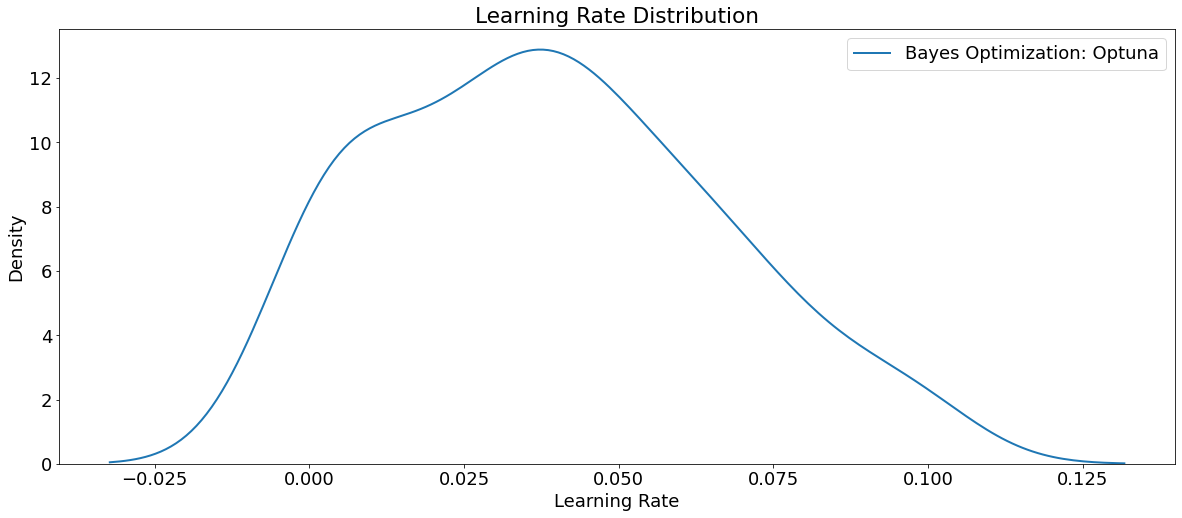

In [29]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

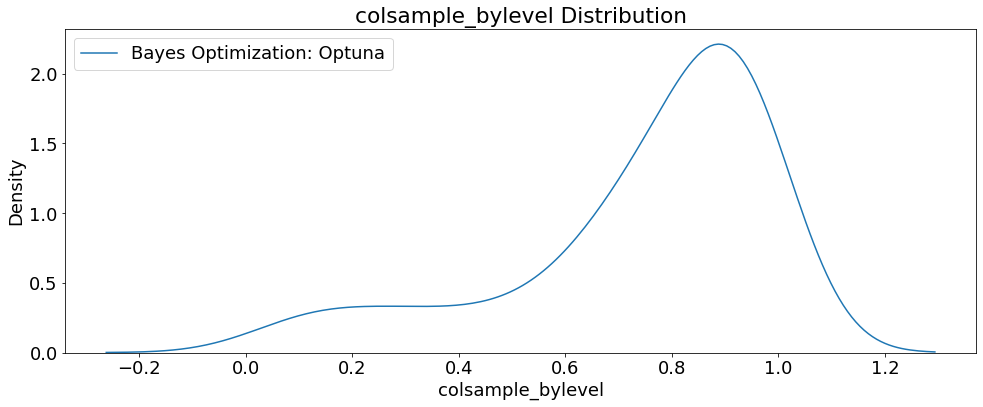

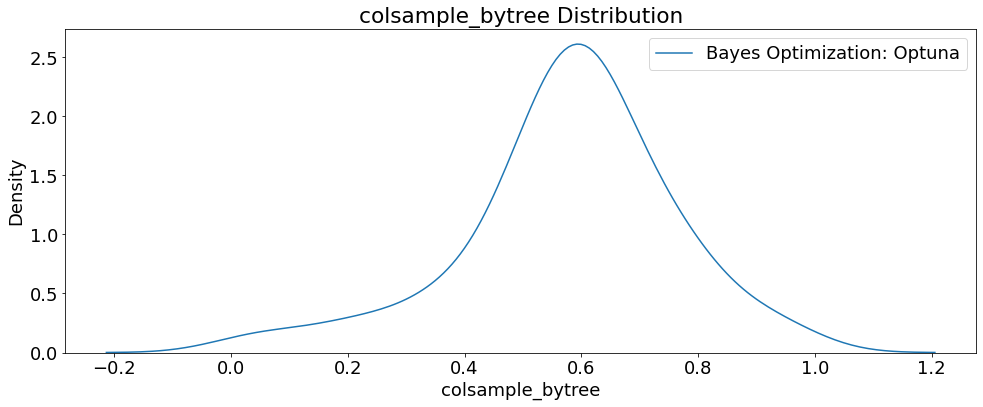

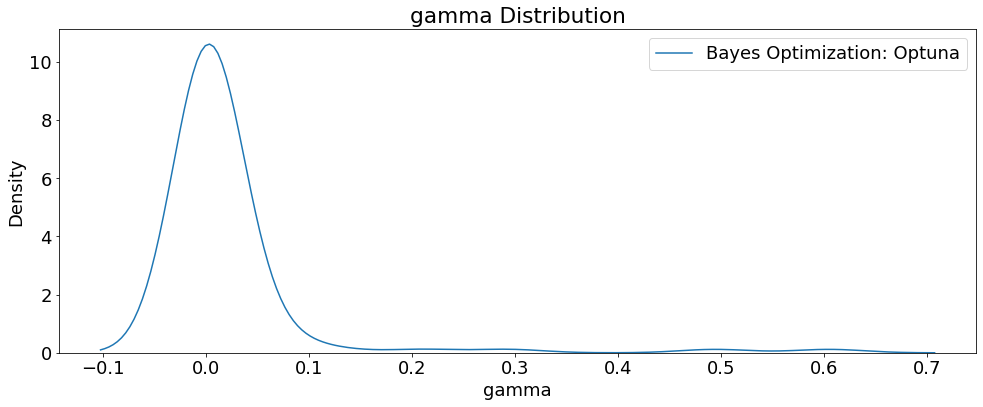

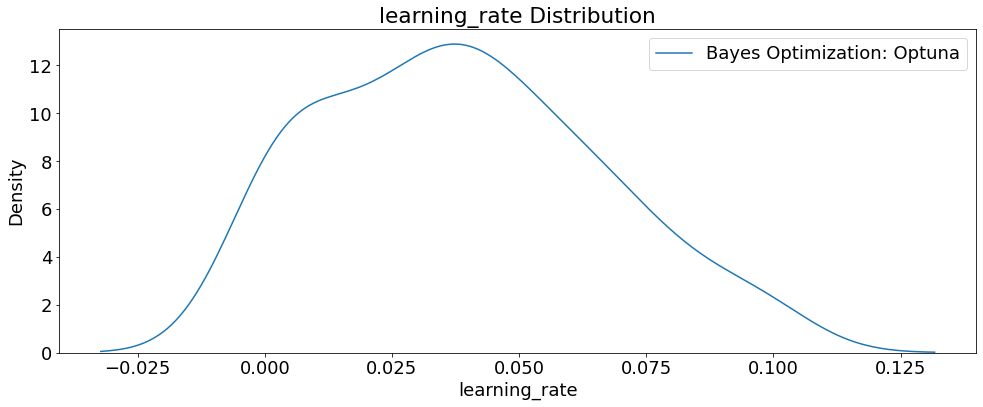

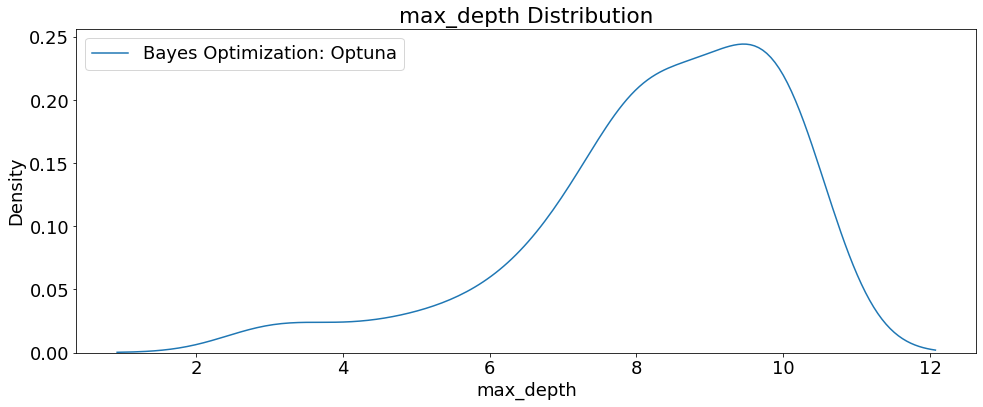

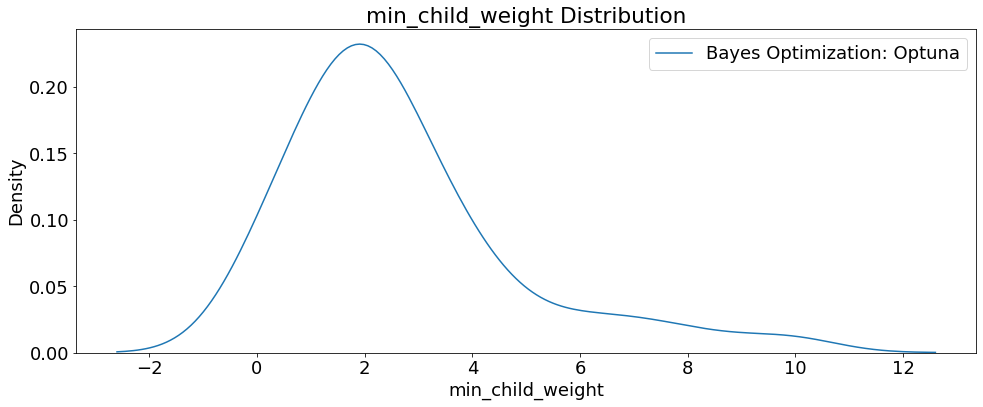

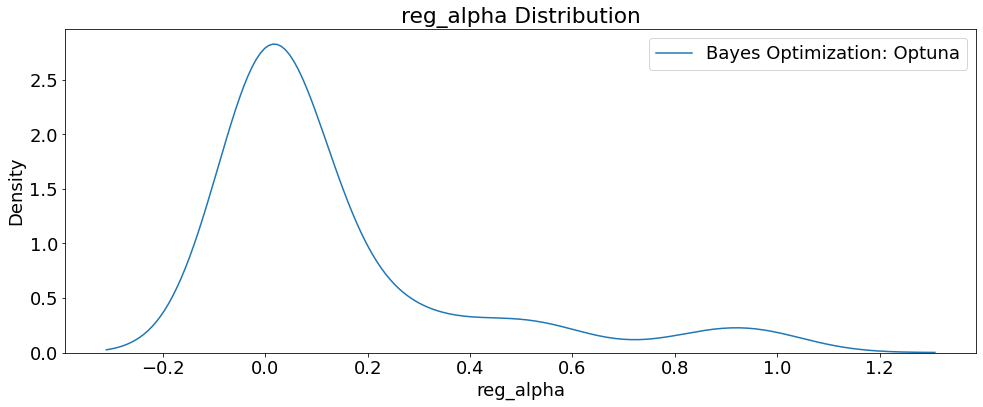

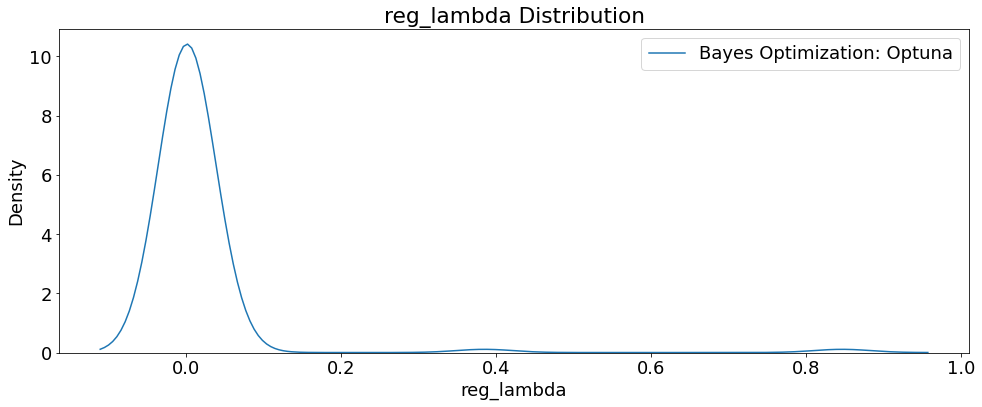

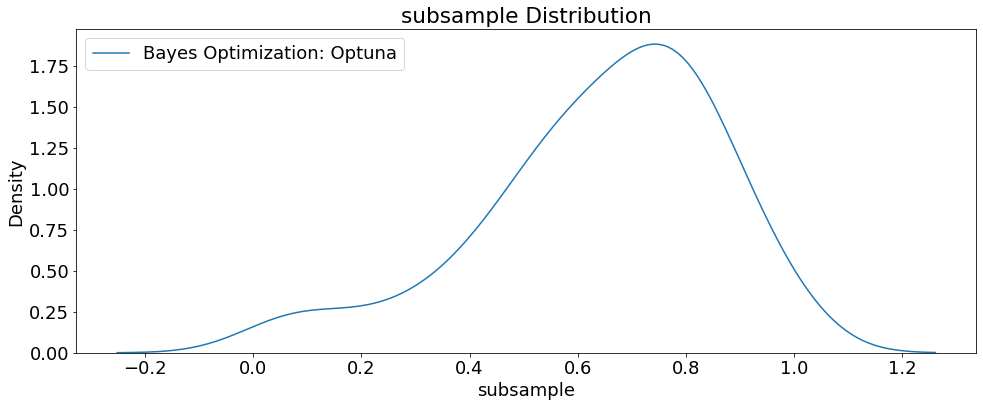

In [30]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

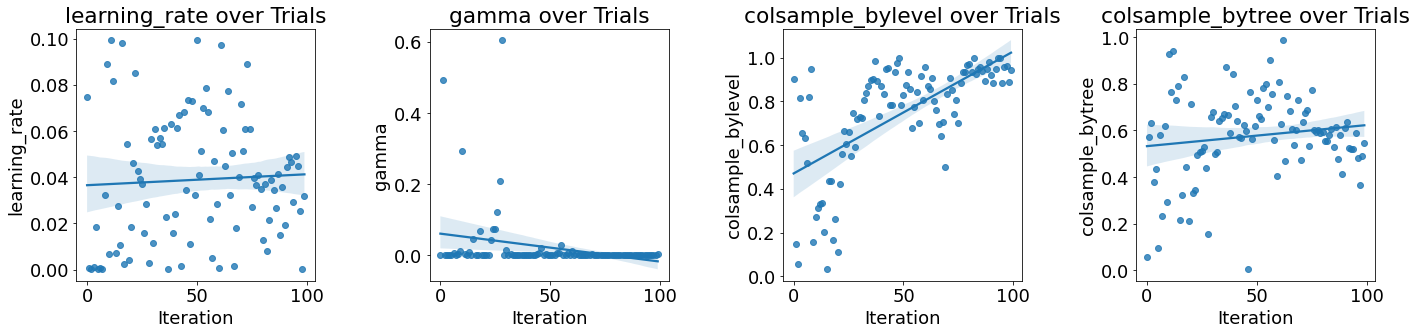

In [31]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



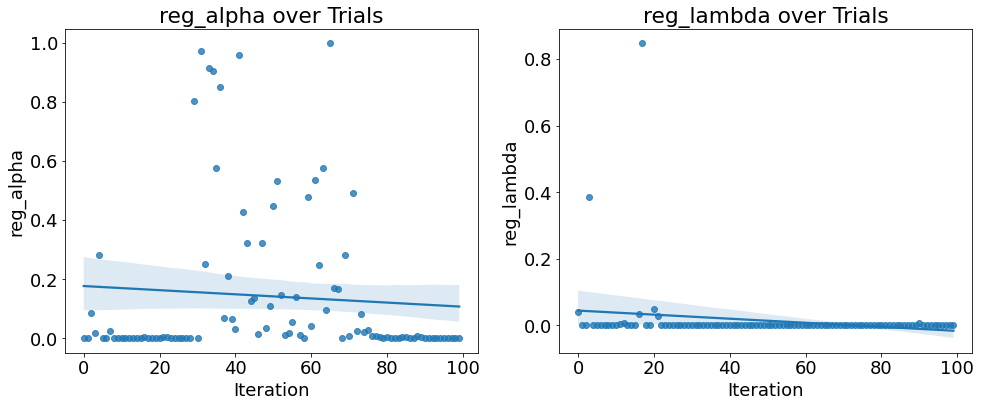

In [32]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [33]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Xgboost_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [34]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Xgboost_Optuna_100_GPU_glove_sentPol.html')
fig.show()

In [35]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'colsample_bylevel': 0.9337293548522074,
 'colsample_bytree': 0.6012556788176429,
 'gamma': 0.0005636001180105738,
 'learning_rate': 0.04098861876027549,
 'loss_function': 'Logloss',
 'max_depth': 10,
 'min_child_weight': 2,
 'n_estimators': 470,
 'random_state': 42,
 'reg_alpha': 0.0022779547211877163,
 'reg_lambda': 0.00020638653154693833,
 'subsample': 0.7733129351737423}

In [36]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/SentimentPolarity/Model_PKL/


study = joblib.load('Xgboost_Optuna_100_GPU_glove_sentPol.pkl')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/SentimentPolarity/Model_PKL


In [37]:
label = df[['sentiment']]

features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, stratify=label)

In [38]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [39]:
# Re-create the best model and train on the training data
best_model = xgb.XGBClassifier(objective='binary:logistic',
                                                booster='gbtree',
                                                tree_method='gpu_hist', 
                                                scale_pos_weight=1,
                                                use_label_encoder=False,
                                                verbosity=0,
                                                n_jobs=-1, 
                                                **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Xgboost_HPO_Optuna_trials100_GPU_glove_sentPol.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Xgboost_HPO_Optuna_trials100_GPU_glove_sentPol.pkl')
# print(model)
# =============================================================================

In [40]:
print('Results from Xgboost HPO Optuna 100 GloVe GPU Sentiment Polarity trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')

print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Xgboost HPO Optuna 100 GloVe GPU Sentiment Polarity trials:


Classification Report: Train
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    331949
           1       0.98      0.98      0.98    331950

    accuracy                           0.98    663899
   macro avg       0.98      0.98      0.98    663899
weighted avg       0.98      0.98      0.98    663899



Confusion matrix: Train
[[325797   6152]
 [  7047 324903]]


Classification Report: Test
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     82988
           1       0.96      0.96      0.96     82987

    accuracy                           0.96    165975
   macro avg       0.96      0.96      0.96    165975
weighted avg       0.96      0.96      0.96    165975



Confusion matrix: Test
[[79657  3331]
 [ 3617 79370]]


Accuracy score: train: 0.980, test: 0.958
Precision score: train: 0.981, test: 0.960
Recall s

In [41]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/SentimentPolarity/trialOptions/

# Access results
trials_df = pd.read_csv('Xgboost_Optuna_100_GPU_glove_sentPol.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/SentimentPolarity/trialOptions


In [42]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.95814 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    78
logloss                                0.112286
datetime_start       2022-04-20 23:14:55.974502
datetime_complete    2022-04-20 23:16:54.379802
duration                 0 days 00:01:58.405300
colsample_bylevel                      0.933729
colsample_bytree                       0.601256
gamma                                  0.000564
learning_rate                          0.040989
max_depth                                    10
min_child_weight                              2
n_estimators                                470
reg_alpha                              0.002278
reg_lambda                             0.000206
subsample                              0.773313
state                                  COMPLETE
Name: 0, dtype: object
